In [1]:
import re
import os

import glob
import shutil

import spacy
from spacy import displacy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
from pyvis.network import Network
import community as community_louvain

In [2]:
! python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
if os.path.isdir('src/htmls'): shutil.rmtree('src/htmls')
if os.path.isdir('src/plots'): shutil.rmtree('src/plots')

os.makedirs('src/htmls')
os.makedirs('src/plots')

In [4]:
character_df = pd.read_csv('data/character_df_cleaned.csv')

In [5]:
def remane_names(name):
    if name == 'Walter White Jr.':
        return re.sub(name, 'Walt Jr.', name)
    return name

In [6]:
character_df.Characters = character_df.Characters.apply(remane_names)
character_df['Characters_firstname'] = character_df.Characters.apply(lambda x : re.sub(r"'s", '', x.split()[0]))
character_df['Characters_lastname'] = character_df.Characters.apply(lambda x : re.sub(r"'s", '', x.split()[-1]))

character_df.head()

,Season,Characters,Characters_firstname,Characters_lastname
0,Season_1,Walter White,Walter,White
1,Season_1,Skyler White,Skyler,White
2,Season_1,Jesse Pinkman,Jesse,Pinkman
3,Season_1,Hank Schrader,Hank,Schrader
4,Season_1,Marie Schrader,Marie,Schrader


In [7]:
NER = spacy.load('en_core_web_sm')

In [8]:
with open('data/summaries/Season_1.txt', 'r') as f:
    sea1_txt = f.read()

In [9]:
sea1_txt = sea1_txt.replace('\n', '\n. ')

In [10]:
ner1 = NER(sea1_txt)

In [11]:
# https://stackoverflow.com/a/51219483
# https://nanonets.com/blog/named-entity-recognition-with-nltk-and-spacy/ : For NLTK

displacy.render(ner1[:500], style = 'ent', jupyter = True)

In [12]:
entity_df = []

for sentence in ner1.sents:
    entity_lis = [ent.text for ent in sentence.ents]
    entity_df.append({'sentence' : sentence, 'entities' : entity_lis})
    
entity_df = pd.DataFrame(entity_df)
entity_df.head()

,sentence,entities
0,"(Walter, is, recording, a, farewell, to, his, ...",[Walter]
1,"(In, the, New, Mexico, desert, ,, a, man, wear...","[New Mexico, RV]"
2,"(In, the, passenger, seat, ,, another, man, is...",[]
3,"(In, the, back, of, the, RV, are, two, bodies, .)","[RV, two]"
4,"(After, crashing, the, RV, in, a, ditch, ,, th...",[RV]


In [13]:
character_df.head()

,Season,Characters,Characters_firstname,Characters_lastname
0,Season_1,Walter White,Walter,White
1,Season_1,Skyler White,Skyler,White
2,Season_1,Jesse Pinkman,Jesse,Pinkman
3,Season_1,Hank Schrader,Hank,Schrader
4,Season_1,Marie Schrader,Marie,Schrader


In [14]:
def filter_entities(entity_list, char_df):
    
    return [entity for entity in entity_list
            if entity in list(char_df.Characters)
            or entity in list(char_df.Characters_firstname)
            or entity in list(char_df.Characters_lastname)]

In [15]:
entity_df['char_entities'] = entity_df.entities.apply(lambda x: filter_entities(x, character_df))
entity_df.head()

,sentence,entities,char_entities
0,"(Walter, is, recording, a, farewell, to, his, ...",[Walter],[Walter]
1,"(In, the, New, Mexico, desert, ,, a, man, wear...","[New Mexico, RV]",[]
2,"(In, the, passenger, seat, ,, another, man, is...",[],[]
3,"(In, the, back, of, the, RV, are, two, bodies, .)","[RV, two]",[]
4,"(After, crashing, the, RV, in, a, ditch, ,, th...",[RV],[]


In [16]:
entity_df = entity_df[entity_df['char_entities'].map(len) > 0]
entity_df.reset_index(inplace = True, drop = True)
entity_df.head()

,sentence,entities,char_entities
0,"(Walter, is, recording, a, farewell, to, his, ...",[Walter],[Walter]
1,"(Recording, a, message, on, the, camcorder, ,,...",[Walter White],[Walter White]
2,"(Walt, walks, onto, the, road, and, awaits, th...",[Walt],[Walt]
3,"(Veggie, bacon, for, Walt, 's, 50th, birthday,...","[Veggie, Walt, 50th]",[Walt]
4,"(Three, weeks, earlier, ,, it, is, Walt, 's, 5...","[Three weeks earlier, Walt, 50th]",[Walt]


In [17]:
def name_correction(name):
    
    if name == 'Elliot' or name == 'Elliott Schwartz' or name == 'Schwartz':
        return 'Elliott'
    
    if name == 'Gretchen Schwartz':
        return 'Gretchen'
    
    if name == 'Gale' or name == 'Boetticher':
        return 'Gale Boetticher'
        
    if name == 'Gus' or name == 'Gustavo Fring' or name in "Gus'":
        return 'Gus Fring'
        
    if name == 'Saul' or name == 'Goodman':
        return 'Saul Goodman'
    
    if name == 'Schrader' or name == 'Hank Schrader':
        return 'Hank'
    
    if name == 'Jesse Pinkman' or name == 'Pinkman':
        return 'Jesse'
    
    if name == 'Mike Ehrmantraut' or name == 'Ehrmantraut':
        return 'Mike'
    
    if name == 'Walter White' or name == 'White' or name == 'Whites' or name == 'Walt':
        return 'Walter'
    
    if name == 'Skyler White':
        return 'Skyler'
    
    if name == 'Tuco':
        return 'Tuco Salamanca'

    if name == 'ASAC' or name == 'George Merkert':
        return 'ASAC George Merkert'

    if name == 'Donald':
        return 'Donald Margolis'
    
    if name == 'Jane':
        return 'Jane Margolis'

    if name == 'Hector':
        return 'Hector Salamanca'
    
    if name == 'APD':
        return 'DEA'
 
    if name == 'Ted' or name == 'Beneke':
        return 'Ted Beneke'
    
    if name in "Jimmy In-'N-Out":
        return 'Jimmy'

    if name == 'Andrea' or name == 'Cantillo':
        return 'Andrea Cantillo'
 
    if name == 'Leonel':
        return 'Leonel Salamanca'

    if name == 'Huell' or name == 'Babineaux':
        return 'Huell Babineaux'
 
    if name == 'Tyrus':
        return 'Tyrus Kitt'
    
    if name == 'Marie Schrader':
        return 'Marie'
 
    if name == 'Max' or name == 'Arciniega':
        return 'Max Arciniega'
    
    if name == 'Dennis':
        return 'Dennis Markowski'
    
    if name == 'Dan':
        return 'Dan Wachsberger'
    
    if name == 'Jack':
        return 'Jack Welker'
    
    if name == 'Todd':
        return 'Todd Alquist'
    
    if name in 'Lydia Rodarte-Quayle':
        return 'Lydia'
    
    if name == 'Peter':
        return 'Peter Schuler'    
    

    return name

In [18]:
relationship = []

for idx in range(entity_df.shape[0]):
    e_idx = min(idx+5, entity_df.shape[0])
    char_list = sum(entity_df.loc[idx:e_idx].char_entities, [])
    char_list = list(map(name_correction, char_list))
    unique_char = [char_list[i] for i in range(len(char_list)) if char_list[i] != char_list[i-1]]
    
    if idx % 220 == 0:
        print(char_list)
        print(unique_char)
        print('\n')

    if len(unique_char) > 1:
        for idx, a in enumerate(unique_char[:-1]):
            b = unique_char[idx + 1]
            relationship.append({'Source' : a, 'Destination' : b})

['Walter', 'Walter', 'Walter', 'Walter', 'Walter', 'Albuquerque', 'Walter']
['Albuquerque', 'Walter']


['Walter', 'Jesse', 'Walter', 'Jesse', 'Walter', 'Walter', 'Jesse', 'Gomez', 'Hank', 'Walter', 'Walter']
['Jesse', 'Walter', 'Jesse', 'Walter', 'Jesse', 'Gomez', 'Hank', 'Walter']




In [19]:
relationship_df = pd.DataFrame(relationship)
print(f"Shape of dataset 'relationship_df' :: {relationship_df.shape}\n")

# relationship_df.Source = relationship_df.Source.apply(lambda x : name_correction(x))
# relationship_df.Destination = relationship_df.Destination.apply(lambda x : name_correction(x))

relationship_df.head(20)

Shape of dataset 'relationship_df' :: (2184, 2)



,Source,Destination
0,Albuquerque,Walter
1,Walter,Albuquerque
2,Albuquerque,Walter
3,Walter,Skyler
4,Walter,Albuquerque
5,Albuquerque,Walter
6,Walter,Skyler
7,Skyler,Walt Jr.
8,Albuquerque,Walter
9,Walter,Skyler


In [20]:
relationship_df['value'] = 1
relationship_df = relationship_df.groupby(['Source', 'Destination'], sort=False, as_index=False).sum()
relationship_df.head(10)

,Source,Destination,value
0,Albuquerque,Walter,6
1,Walter,Albuquerque,2
2,Walter,Skyler,130
3,Skyler,Walt Jr.,5
4,Walt Jr.,Walter,5
5,Skyler,Walter,86
6,Walter,Hank,59
7,Hank,DEA,6
8,DEA,Hank,5
9,Hank,Walter,73


In [21]:
G = nx.from_pandas_edgelist(relationship_df, source = 'Source', target = 'Destination', edge_attr = 'value', create_using = nx.Graph())

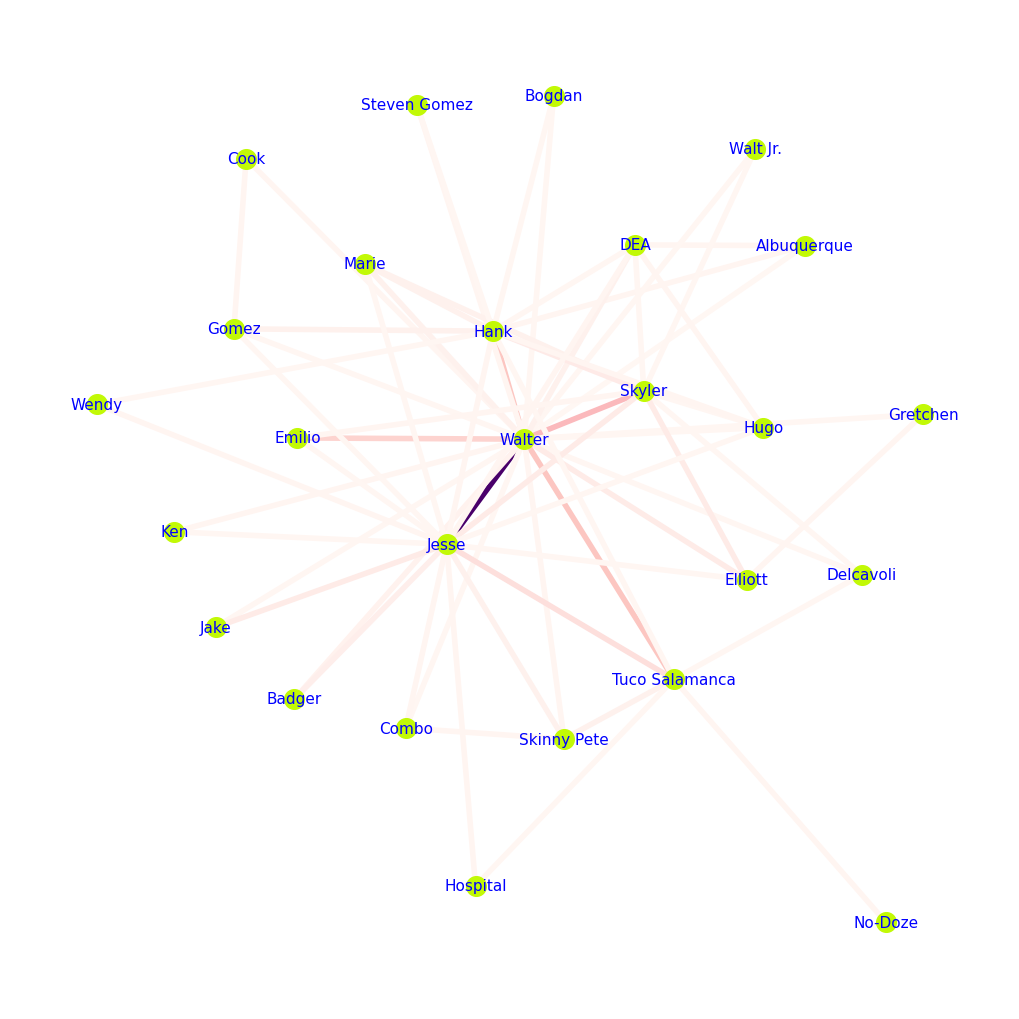

In [22]:
# https://stackoverflow.com/a/22971333
   
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)

Weights =  nx.get_edge_attributes(G, 'value').values()

arggs = {
        'with_labels' : 'True',
        'node_size' : 200,
        'node_color' : '#C2F906',
        'edge_color' : Weights, 
        "edge_cmap": plt.cm.RdPu,
        'width' : 4,
        'font_size' : 11,
        'font_color' : 'blue'
        }

nx.draw(G, pos = pos, **arggs)
plt.show()

In [23]:
# https://pyvis.readthedocs.io/en/latest/tutorial.html#example-visualizing-a-game-of-thrones-character-network

net = Network(notebook = True, width = '950px', height = '800px', bgcolor = '#222222', font_color = 'white')

node_degree = dict(G.degree)

nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
# net.save_graph('src/htmls/S01.html')
net.show('src/htmls/S01.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [24]:
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, 'group')

print(f"Type of 'partition' :: {type(partition)}\n\n{partition}") 

Type of 'partition' :: <class 'dict'>

{'Albuquerque': 0, 'Walter': 3, 'Skyler': 2, 'Walt Jr.': 2, 'Hank': 0, 'DEA': 0, 'Marie': 2, 'Bogdan': 0, 'Steven Gomez': 0, 'Gomez': 3, 'Cook': 3, 'Jesse': 3, 'Emilio': 2, 'Wendy': 0, 'Combo': 3, 'Skinny Pete': 3, 'Ken': 3, 'Jake': 3, 'Delcavoli': 1, 'Badger': 3, 'Elliott': 3, 'Gretchen': 3, 'Hugo': 0, 'Tuco Salamanca': 1, 'Hospital': 1, 'No-Doze': 1}


In [25]:
net = Network(notebook = True, width = '950px', height = '800px', bgcolor = '#222222', font_color = 'white')
net.from_nx(G, )
# net.save_graph('src/htmls/S01_Communities.html')
net.show('src/htmls/S01_Communities.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [26]:
summaries = sorted(glob.glob('data/summaries/*.txt'), reverse = False)

In [27]:
styles = [dict(selector='caption', props=[('text-align', 'center'),
                                          ('font-size', '100%'),
                                          ('color', '#135EA9'),
                                          ('background-color' , '#F6E7DB')])]

In [28]:
def generate_spacy_tokens(filename):
    
    with open(filename, 'r') as f:
        summary = f.read()
        
    summary = summary.replace('\n', '\n. ')
    
    summary = NER(summary)
    
    # displacy.render(summary[:500], style = 'ent', jupyter = True)
    
    return summary

In [29]:
def generate_entity_datafrane(summary):
    entity_df = []

    for sentence in summary.sents:
        entity_lis = [ent.text for ent in sentence.ents]
        entity_df.append({'sentence' : sentence, 'entities' : entity_lis})

    entity_df = pd.DataFrame(entity_df)
    
    # display(entity_df.head().style.set_caption('entity_df').set_table_styles(styles))
    
    return entity_df

In [30]:
def clean_entity_df(df, char_df):
    
    df['char_entities'] = df.entities.apply(lambda x: filter_entities(x, char_df))
    df = df[df['char_entities'].map(len) > 0]
    df.reset_index(inplace = True, drop = True)
    
    # display(df.head().style.set_caption('cleaned entity_df').set_table_styles(styles))
    
    return df

In [31]:
def generate_relationships(df):
    
    relationship = []

    for idx in range(df.shape[0]):
        e_idx = min(idx+5, df.shape[0])
        char_list = sum(df.loc[idx:e_idx].char_entities, [])

        char_list = list(map(name_correction, char_list))

        unique_char = [char_list[i] for i in range(len(char_list)) if char_list[i] != char_list[i-1]]
        
        if len(unique_char) > 1:
            for idx, a in enumerate(unique_char[:-1]):
                b = unique_char[idx + 1]
                relationship.append({'Source' : a, 'Destination' : b})
                
    return pd.DataFrame(relationship)

In [32]:
def generate_graph_weights(df):
    
    df['value'] = 1
    df = df.groupby(['Source', 'Destination'], sort=False, as_index=False).sum()
    
    # display(df.head(10).style.set_caption('WT_relationship_df').set_table_styles(styles))
    
    return df

In [33]:
def generate_map(filename):
    
    summary = generate_spacy_tokens(filename)
    
    entity_df = generate_entity_datafrane(summary)
    
    entity_df = clean_entity_df(entity_df, character_df)
    
    relationship_df = generate_relationships(entity_df)
    
    # display(relationship_df.head(10).style.set_caption('relationship_df').set_table_styles(styles))
    
    # print(f"Shape of dataset 'relationship_df' :: {relationship_df.shape}\n")
    
    relationship_df = generate_graph_weights(relationship_df)
    
    # print(f"Shape of dataset 'WT_relationship_df' :: {relationship_df.shape}\n")
    
    return nx.from_pandas_edgelist(relationship_df,
                                   source = 'Source',
                                   target = 'Destination',
                                   edge_attr = 'value',
                                   create_using = nx.Graph())

In [34]:
map_dict = {}

for season in summaries:
    
    key = season.split('/')[-1]
    key = key.split('.')[0]
    # print(key)
    
    map_dict[key] = generate_map(season)
    
map_dict

{'Season_1': <networkx.classes.graph.Graph at 0x7fd9d55f4520>,
 'Season_2': <networkx.classes.graph.Graph at 0x7fd9c9ee0370>,
 'Season_3': <networkx.classes.graph.Graph at 0x7fd9c9ee0280>,
 'Season_4': <networkx.classes.graph.Graph at 0x7fd9c9ee0340>,
 'Season_5A': <networkx.classes.graph.Graph at 0x7fd9c9de16f0>,
 'Season_5B': <networkx.classes.graph.Graph at 0x7fd9c9cc39d0>}

In [35]:
def community_plot(graph_object, season):
    
    partition = community_louvain.best_partition(graph_object)
    
    nx.set_node_attributes(graph_object, partition, 'group')
    
    net = Network(notebook = True, width = '950px', height = '800px', bgcolor = '#222222', font_color = 'white')

    net.from_nx(graph_object)
    
    return net.show(f'src/htmls/{season}_Communities.html')

In [36]:
# https://stackoverflow.com/a/10035974
# https://engineeringfordatascience.com/posts/matplotlib_subplots/

def plot_centrality(graph_object, season):
    
    nx_centralities = [nx.degree_centrality, nx.closeness_centrality, nx.betweenness_centrality, nx.eigenvector_centrality]
    centralities = ['Degree', 'Closeness', 'Betweenness', 'EigenVector']
    
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))
    plt.subplots_adjust(hspace = 0.3)
    
    fig.suptitle(f'{season} : Character importance', fontsize = 18, y = 0.95)
    
    axs = axs.ravel()
    
    for idx, (title, nx_graph) in enumerate(zip(centralities, nx_centralities)):
        
        top_5_chars = dict(sorted(nx_graph(graph_object).items(), key = lambda x : x[1], reverse = True)[:5])
        
        sns.barplot(x = list(top_5_chars.keys()), y = list(top_5_chars.values()), ax = axs[idx])
        
        axs[idx].set_title(f'Based on : {title} centrality')
        
    plt.savefig(f'src/plots/{season}_char_imp.svg', bbox_inches = 'tight', pad_inches = 0.3)
    
    plt.show()

In [37]:
community_plot(map_dict['Season_1'], 'Season_1')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


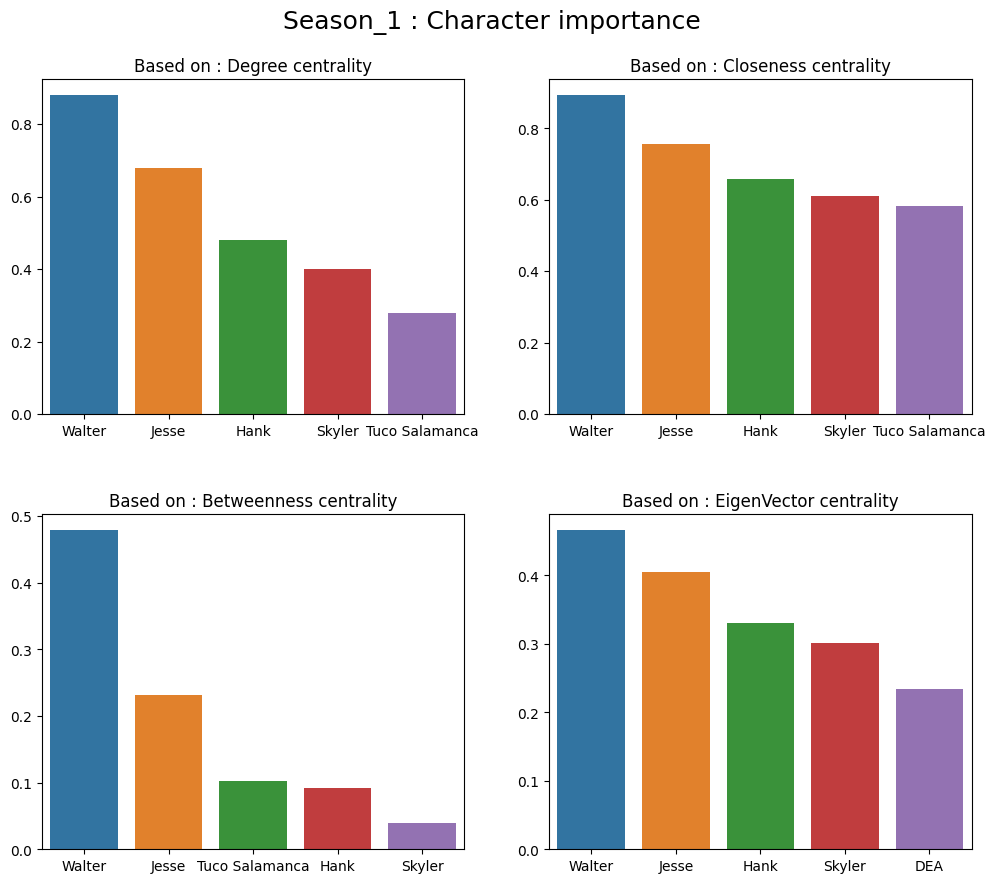

In [38]:
plot_centrality(map_dict['Season_1'], 'Season_1')

In [39]:
community_plot(map_dict['Season_2'], 'Season_2')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


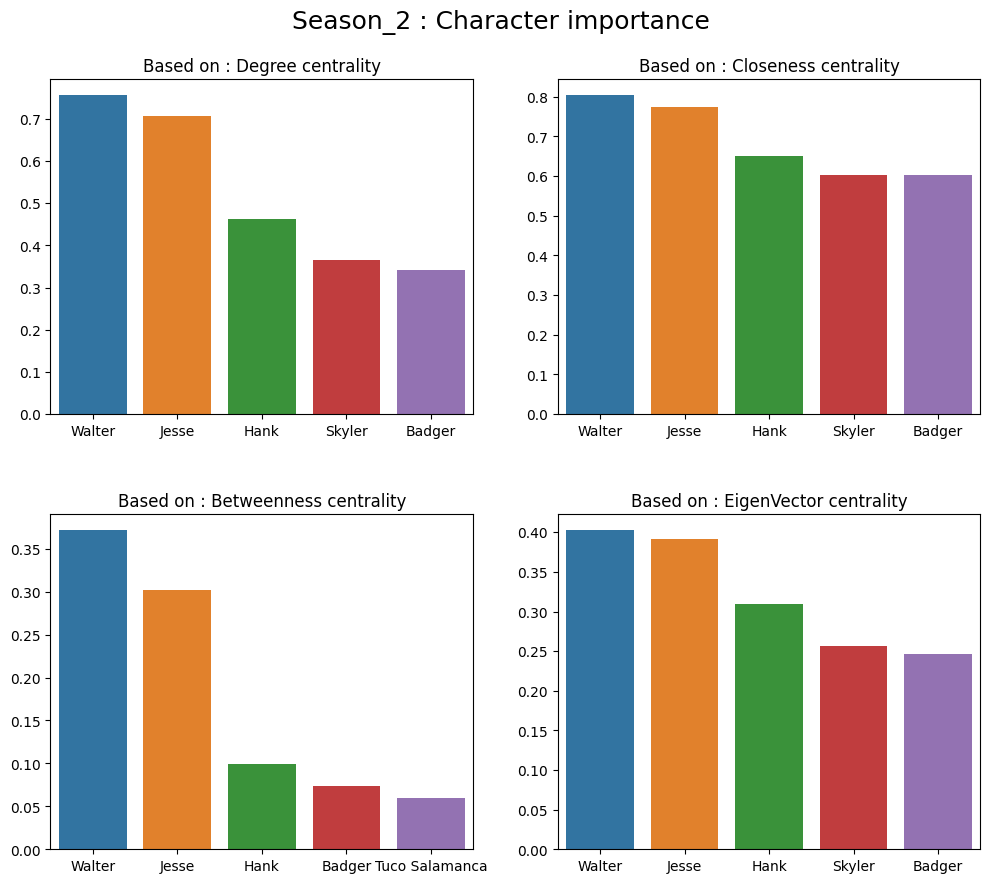

In [40]:
plot_centrality(map_dict['Season_2'], 'Season_2')

In [41]:
community_plot(map_dict['Season_3'], 'Season_3')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


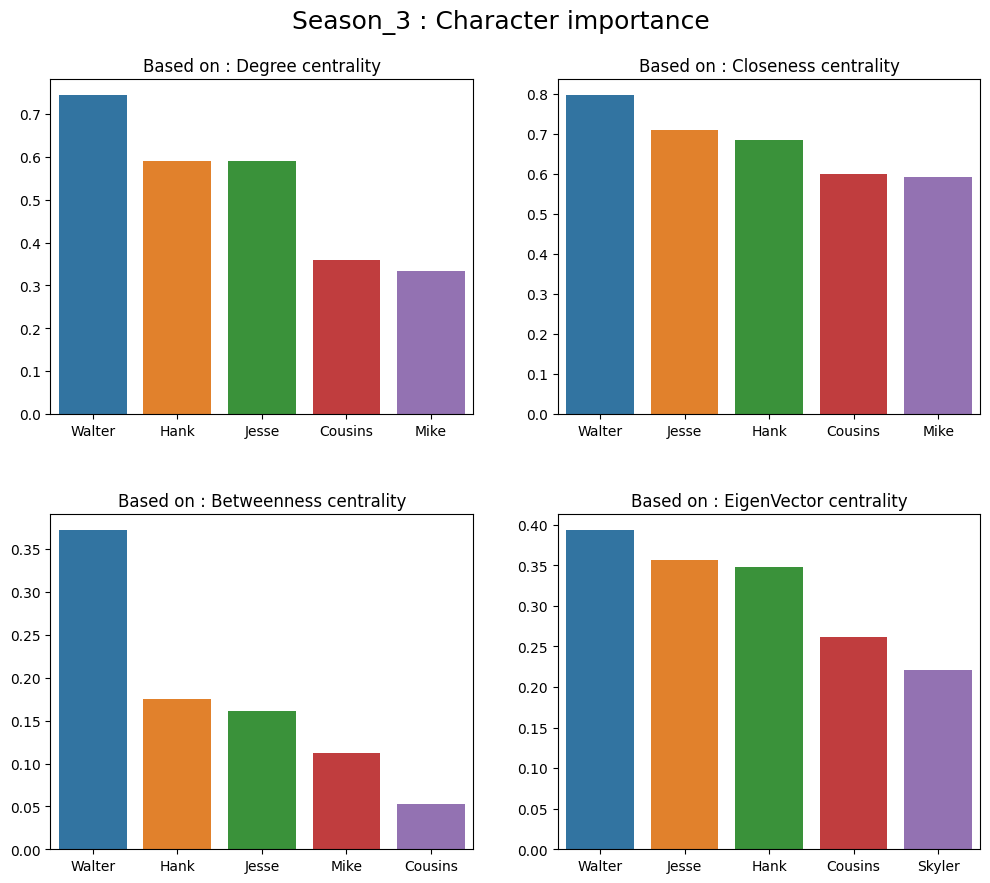

In [42]:
plot_centrality(map_dict['Season_3'], 'Season_3')

In [43]:
community_plot(map_dict['Season_4'], 'Season_4')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


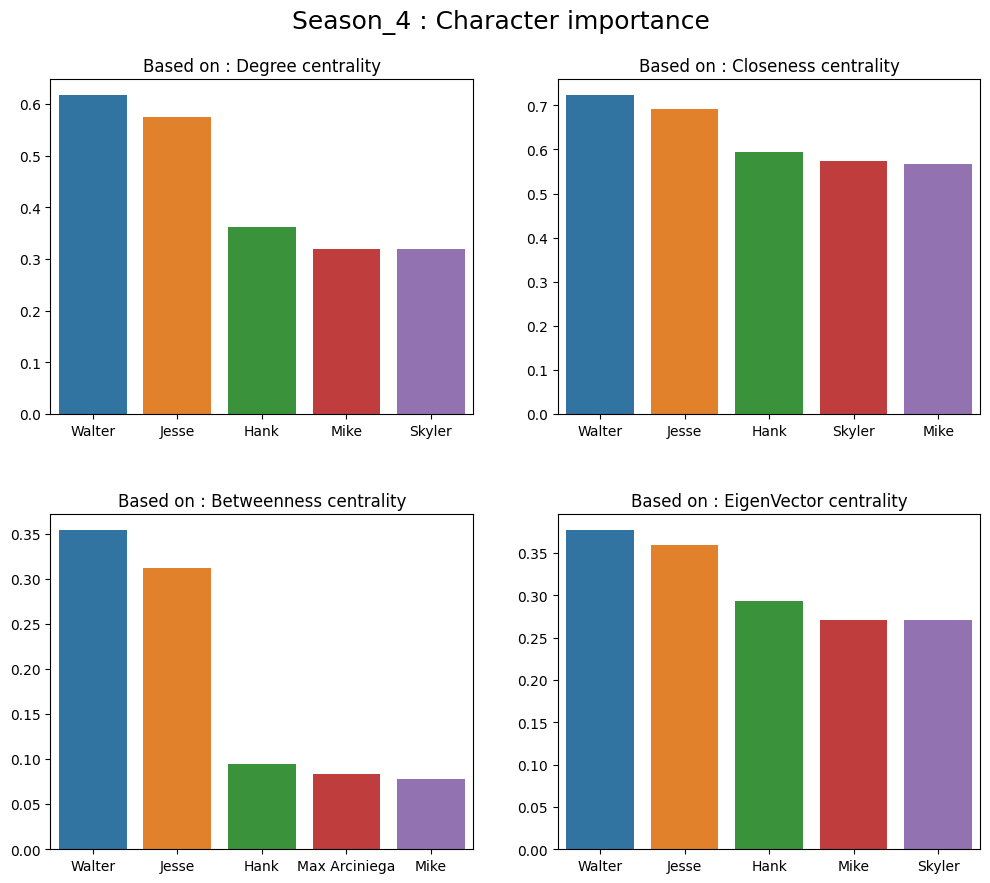

In [44]:
plot_centrality(map_dict['Season_4'], 'Season_4')

In [45]:
community_plot(map_dict['Season_5A'], 'Season_5A')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


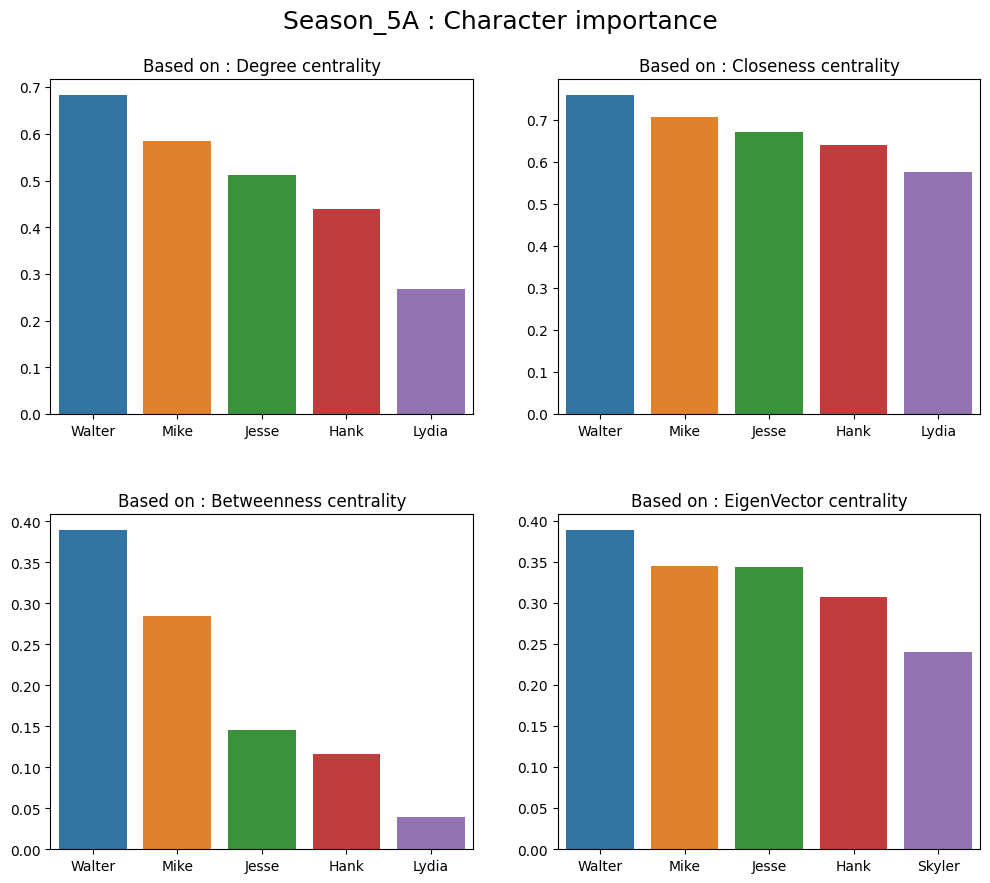

In [46]:
plot_centrality(map_dict['Season_5A'], 'Season_5A')

In [47]:
community_plot(map_dict['Season_5B'], 'Season_5B')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


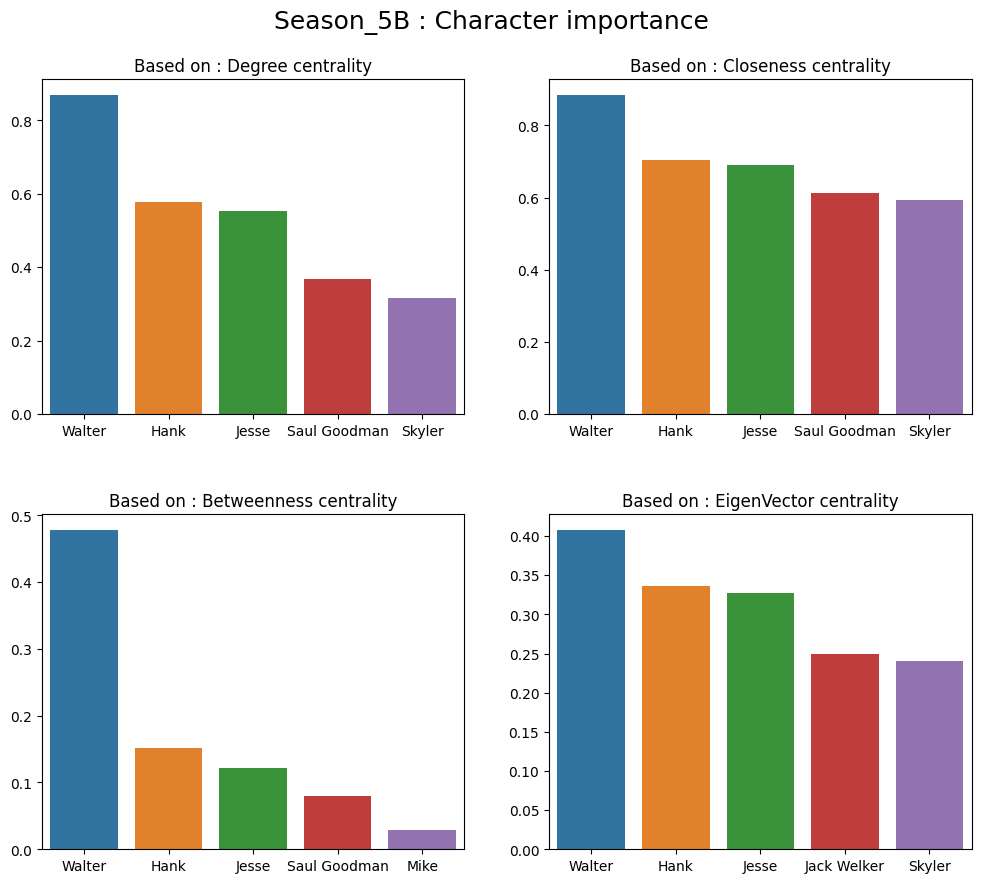

In [48]:
plot_centrality(map_dict['Season_5B'], 'Season_5B')